In [1]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [504]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'

In [3]:
'''Functions to calculate energy and frequencies in isochrone potential'''

def H(J_r, L):
    return -0.5*GM**2 / (J_r + 0.5*(L + np.sqrt(L**2 + 4*GM*b)))**2

def calc_Omega_r(J_r, L):
    return GM**2 / (J_r + 0.5*(L + np.sqrt(L**2 + 4*GM*b)))**3

def calc_Omega_phi(J_r, L, J_phi):
    return 0.5*(1 + L/np.sqrt(L**2 + 4*GM*b)) * calc_Omega_r(J_r, L) * np.sign(J_phi)

In [66]:
'''Choose potential parameters'''
import astropy.units as u
from astropy.constants import G

# Choose Solar radius and local circular velocity
r0 = 8.2
v0 = 238

# Choose scale radius and bar pattern speed
b = 3

# Calculate mass required to satisfy above requirements
a = np.sqrt(b**2 + r0**2)
GM = v0**2 * ((b+a)**2 * a)/r0**2
M = (GM*(u.km/u.s)**2*u.kpc / G).to(u.Msun).value

def Phi(r):
    return -GM / (b + np.sqrt(b**2 + r**2))

def v_c(r):
    a = np.sqrt(b**2 + r**2)
    return (GM * r**2 / ((b + a)**2 * a))**0.5

pot = agama.Potential(type='isochrone', mass=M, scaleRadius=b)

In [71]:
'''Define bar potential radial profile'''

# Set bar strength and scale length
A = 0.02
b_bar = 0.28

def Phi_bar(r, Omega_b):
    # Calculate corotation radius
    r_CR = v0 / Omega_b
    
    # rgrid = np.linspace(0.01, 20, 1000)
    # Omega_c = v_c(rgrid) / rgrid
    # R_CR = rgrid[np.argmin(abs(Omega_c - Omega_b))]

    return -0.5 * A * v0**2 * (r / r_CR)**2 * ((b_bar + 1) / (b_bar + r / r_CR))**5


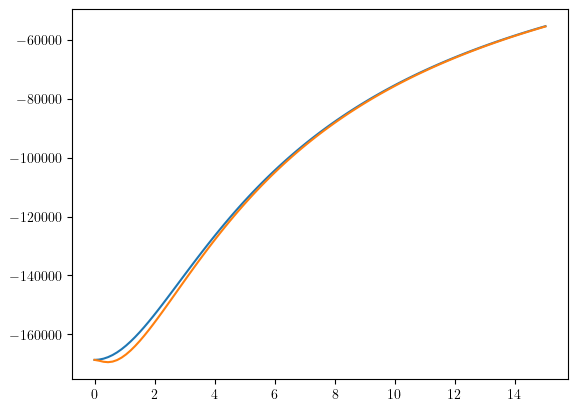

In [72]:
Rgrid = np.linspace(0, 15, 101)

Phi_b = Phi_bar(Rgrid, 35)

# plt.plot(Rgrid, Phi_b)

plt.plot(Rgrid, Phi(Rgrid))

plt.plot(Rgrid, Phi(Rgrid) + Phi_b)

In [86]:
'''Calculate orbits'''

L_z = 100
J_r = 100

def calc_orbit(L_z, J_r, phi_peri):
    L = np.abs(L_z)
    J_phi = L_z

    E = H(J_r, L)
    Omega_r = calc_Omega_r(J_r, L)
    Omega_phi = calc_Omega_phi(J_r, L, J_phi)

    # Calculate theta_r from uniform grid in eta
    N = 101
    N_r_period = 1

    eta = np.linspace(0, 1, N+1) * 2*np.pi*N_r_period
    eta_over_pi = eta / np.pi
    c = GM/(-2*E) - b
    e = (1 - L**2/(GM*c) * (1 + b/c))**0.5

    theta_r = eta - e*c/(c + b) * np.sin(eta)

    # Calculate radius
    s = 2 + c/b * (1 - e*np.cos(eta))
    r = b*np.sqrt((s-1)**2 - 1)

    # Calculate theta and phi
    theta_phi = Omega_phi/Omega_r * theta_r + phi_peri

    phi_shift = 0.5*np.pi*(eta_over_pi - eta_over_pi % 4)*(1 + 1/np.sqrt(1 + 4*GM*b/L**2))*np.sign(J_phi)

    phi = theta_phi - Omega_phi/Omega_r * theta_r + np.sign(J_phi) * (np.arctan2(np.sqrt((1+e)/(1-e)) * np.sin(eta/2), np.cos(eta/2))%(2*np.pi) + 1/np.sqrt(1 + 4*GM*b/L**2) * (np.arctan2(np.sqrt((1+e+2*b/c)/(1-e+2*b/c)) * np.sin(eta/2), np.cos(eta/2))%(2*np.pi))) + phi_shift

    return r, phi, theta_r, theta_phi, Omega_r, Omega_phi

# r, phi, theta_r, theta_phi, Omega_r, Omega_phi = calc_orbit(L_z, J_r, 0)

# plt.plot(theta_r, r)

In [385]:
'''Calculate 3D orbits'''

def calc_orbit_3D(J_r, L, J_phi, psi_peri, Omega):
    J_r = np.asarray(J_r)
    L = np.asarray(L)
    J_phi = np.asarray(J_phi)
    psi_peri = np.asarray(psi_peri) 
    Omega = np.asarray(Omega)

    E = H(J_r, L)
    Omega_r = calc_Omega_r(J_r, L)
    Omega_phi = calc_Omega_phi(J_r, L, J_phi)
    Omega_theta = np.abs(Omega_phi)

    inc = np.arccos(np.clip(J_phi / L, -1, 1))  # Ensure valid input range

    # Calculate theta_r from uniform grid in eta
    N = 100
    N_r_period = 1

    eta = np.linspace(0, 1, N+1) * 2 * np.pi * N_r_period
    eta = eta[:, np.newaxis]  # Ensure correct broadcasting

    eta_over_pi = eta / np.pi
    c = GM / (-2 * E) - b
    e = np.sqrt(1 - L**2 / (GM * c) * (1 + b / c))

    theta_r = eta - (e * c / (c + b)) * np.sin(eta)

    # Calculate radius
    s = 2 + c / b * (1 - e * np.cos(eta))
    r = b * np.sqrt((s - 1)**2 - 1)

    # Calculate theta and phi
    theta_theta = Omega_theta / Omega_r * theta_r + psi_peri
    theta_phi = Omega + np.sign(J_phi) * theta_theta

    psi_shift = (
        0.5 * np.pi * (eta_over_pi - eta_over_pi % 4) * (1 + 1 / np.sqrt(1 + 4 * GM * b / L**2)) * np.sign(J_phi)
    )

    psi = (
        theta_theta - Omega_theta / Omega_r * theta_r
        + np.arctan2(np.sqrt((1 + e) / (1 - e)) * np.sin(eta / 2), np.cos(eta / 2)) % (2 * np.pi)
        + 1 / np.sqrt(1 + 4 * GM * b / L**2) * (
            np.arctan2(
                np.sqrt((1 + e + 2 * b / c) / (1 - e + 2 * b / c)) * np.sin(eta / 2),
                np.cos(eta / 2)
            ) % (2 * np.pi)
        ) + psi_shift
    )

    cos_theta = np.sin(inc) * np.sin(psi)
    theta = np.arccos(np.clip(cos_theta, -1, 1))  # Clip to ensure valid range

    # Ensure the angle u is in the correct quadrant
    sin_u = 1 / np.tan(inc) * 1 / np.tan(theta)
    sin_u = np.clip(sin_u, -1, 1)  # Ensure valid range
    cos_u = np.sqrt(1 - sin_u**2) * np.sign(np.cos(psi))

    u = np.arctan2(sin_u, cos_u)
    phi = u + Omega

    return r, theta, phi, theta_r, theta_theta, theta_phi, Omega_r, Omega_theta, Omega_phi


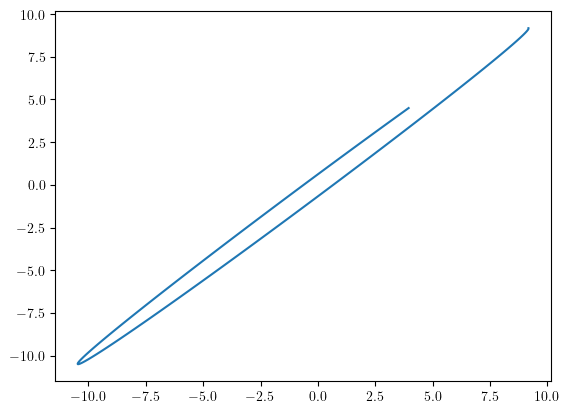

In [ ]:
'''Test orbit calculation'''

J_r = 10#np.array([10, 20])
L = 3000#np.array([3000, 3500])
J_phi = -100#np.array([100, 200])
psi_peri = 0
Omega = np.pi/4

r, theta, phi, theta_r, theta_theta, theta_phi, Omega_r, Omega_theta, Omega_phi = calc_orbit_3D(J_r, L, J_phi, psi_peri, Omega)

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

plt.plot(x, y)


In [386]:
'''Calculate change in Lz per orbit'''
from scipy.integrate import simpson
import matplotlib.colors as mcolors

def calc_Delta_Lz(J_r, L, J_phi, Omega_b, psi_peri, Omega):
    r, theta, phi, theta_r, theta_theta, theta_phi, Omega_r, Omega_theta, Omega_phi = calc_orbit_3D(J_r, L, J_phi, psi_peri, Omega)

    integrand = Phi_bar(r, Omega_b) * np.sin(theta)**2 * np.sin(2*(phi - Omega_b/Omega_r * theta_r))

    Delta_Lz = 2 / Omega_r * simpson(y=integrand, x=theta_r, axis=0)

    return Delta_Lz

def calc_D(J_r, L, J_phi, Omega_b):
    psi_peri_grid = np.linspace(0, 2*np.pi, 21)
    Omega_grid = np.linspace(0, np.pi, 11)
    Delta_Lz_grid = np.zeros((len(psi_peri_grid), len(Omega_grid), len(J_r)))
    for i in range(len(psi_peri_grid)):
        for j in range(len(Omega_grid)):
            Delta_Lz_grid[i,j] = calc_Delta_Lz(J_r, L, J_phi, Omega_b, psi_peri_grid[i], Omega_grid[j])
    
    mean_Delta_Lz2 = 1/(2*np.pi) * simpson(y=Delta_Lz_grid**2, x=psi_peri_grid, axis=0)
    mean_Delta_Lz2 = 1/(np.pi) * simpson(y=mean_Delta_Lz2, x=Omega_grid, axis=0)

    Omega_r = calc_Omega_r(J_r, L)
    tau = 2*np.pi / Omega_r

    return 0.5 * mean_Delta_Lz2 / tau


In [376]:
L_z = np.array([100, 200])
J_r = np.array([500, 600])
L = np.array([1000, 2000])

psi_peri_grid = np.linspace(0, 2*np.pi, 21)[:-1]

# print(psi_peri_grid[5])

print(calc_Delta_Lz(J_r, L, L_z, psi_peri_grid[5], 0, 60))

(101, 2)
[-8.27182698 42.18664053]


In [377]:
Omega_b = 35

L_z = np.random.normal(0, 1000, 1000)
L = np.abs(L_z)
J_r = np.abs(np.random.normal(0, 1000, 1000))
E = H(J_r, L)

D = np.zeros(len(L_z))

# for i in range(len(L_z)):
D = calc_D(J_r, L, L_z, Omega_b)

/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_59351/1870333403.py:57: RuntimeWarning: divide by zero encountered in divide
  sin_u = 1 / np.tan(inc) * 1 / np.tan(theta)


(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101, 1000)
(101

(0.0, 6000.0)

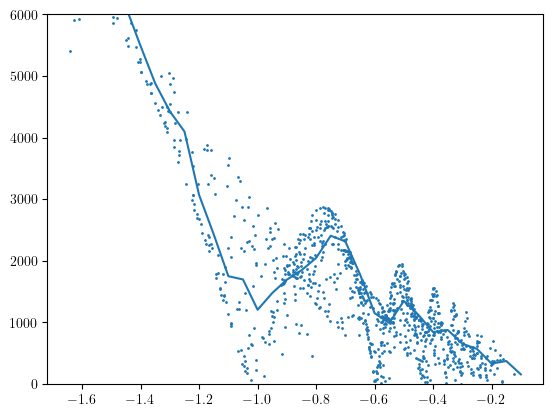

In [379]:
from scipy.stats import binned_statistic

tbar = 8
spread = 2*D**0.5 * tbar

plt.scatter(E/1e5, spread, s=1)
E_bins = np.linspace(-1.5, 0, 31)

D_median = binned_statistic(E/1e5, spread, statistic='median', bins=E_bins)[0]

plt.plot(E_bins[1:], D_median)

plt.ylim(0, 6000)

5.373133585323178


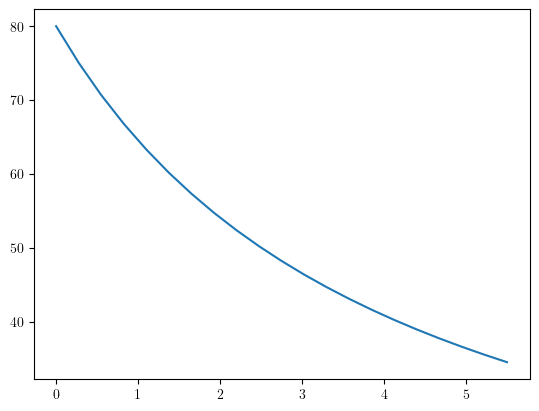

In [718]:
'''Specify pattern speed evolution and distribution function'''

eta = 0.003
Omega_b_0 = 80
Omega_b_f = 34.5

def Omega_b_slow(t):
    return Omega_b_0 / (1 + eta * Omega_b_0 * t)

tf = (Omega_b_0/Omega_b_f - 1)/(eta * Omega_b_0)

tf_Gyr = (tf*u.s*u.kpc/u.km).to(u.Gyr).value

print(tf_Gyr)

t = np.linspace(0, tf, 21)
Omega_b = Omega_b_slow(t)

plt.plot(t, Omega_b)


In [ ]:
# Generate points from GC-like DF
Nbody = 2000
df_GC = agama.DistributionFunction(type='DoublePowerLaw', norm=1e9, slopeOut=5.03, slopeIn=1.23, steepness=1.08, coefJrOut=0.65, coefJzOut=1.32, coefJrIn=1.86, coefJzIn=1.01, J0=10**3.08, rotFrac=0)
xv, mass = agama.GalaxyModel(pot, df_GC).sample(Nbody)

af = agama.ActionFinder(pot)
act = af(xv)

L_z = act[:,2]
J_r = act[:,0]
J_z = act[:,1]

# L_z = np.random.normal(0, 1000, 100)
L = np.linalg.norm(np.cross(xv[:,0:3], xv[:,3:6]), axis=-1)
# J_r = np.abs(np.random.normal(0, 1000, 100))
E = H(J_r, L)

In [708]:
'''Calculate diffusion coefficient and weighted means of Omega'''

D = np.zeros((len(t), len(L_z)))

for i in range(len(t)):
    D[i] = calc_D(J_r, L, L_z, Omega_b[i])
    
D_mean = simpson(y=D, x=t, axis=0) / (t[-1] - t[0])

Omega_b_mean = simpson(y=Omega_b[:,np.newaxis] * D, x=t, axis=0) / (D_mean * (t[-1] - t[0]))
Omega_b2_mean = simpson(y=Omega_b[:,np.newaxis]**2 * D, x=t, axis=0) / (D_mean * (t[-1] - t[0]))

alpha = Omega_b2_mean / Omega_b_mean**2 - 1

In [675]:
'''Calculate resonances'''

def H_res(L, J_phi, l, m, Omega_b):
    A = -0.5*(GM*Omega_b)**(2/3)
    return A * (0.5*(np.sign(J_phi) + L*np.sign(J_phi)/np.sqrt(L**2 + 4*GM*b)) + l/m)**(-2/3)

<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\s'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_59351/3213324378.py:47: SyntaxWarning: invalid escape sequence '\s'
  cb.set_label('$\sigma_{L_z}/L_{z\odot}$', fontsize=14)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_59351/3213324378.py:72: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_title('Substructure 1$\sigma$ ellipses', fontsize=16)


[0.01339329 0.00031797 0.06552535 ... 0.11384614 0.13821397 0.25310196]


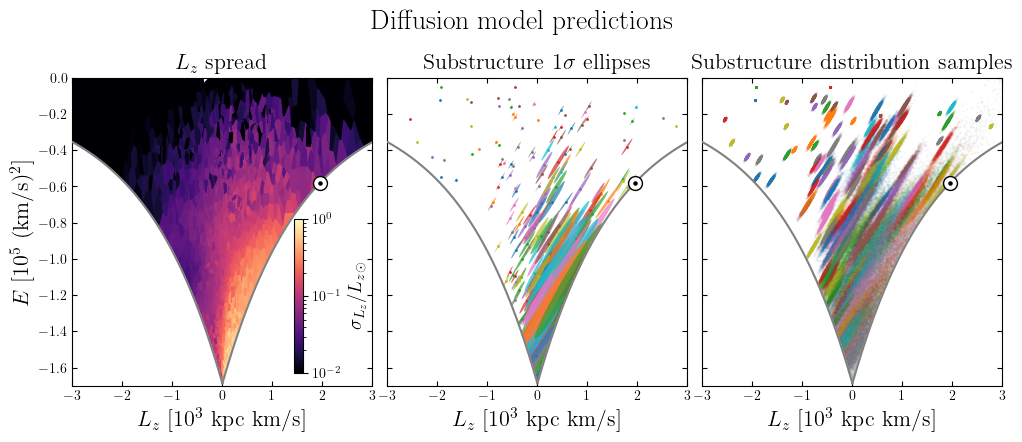

In [788]:
'''Plot mean diffusion coefficient'''

from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.cm as cm

sigma_Lz = np.sqrt(2 * D_mean * t[-1])

Omega_0 = 1e2
Lz_scale = 1e3

Lz0 = r0 * v_c(r0)
E0 = H(0, Lz0)

sigma_E = sigma_Lz * Omega_b2_mean**0.5

points = np.stack((L_z/1e3, E/1e5)).T
vor = Voronoi(points)

fig, axs = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

voronoi_plot_2d(vor, ax=axs[0], show_vertices=False, show_points=False, line_alpha=0)

values = sigma_Lz / Lz0#1e3

print(values)

norm = mcolors.LogNorm(vmin=1e-2, vmax=1)#mcolors.LogNorm(vmin=1e-2, vmax=1e2)
cmap = cm.magma
colors = cmap(norm(values))
for i, point in enumerate(points):
    region_index = vor.point_region[i]  # Get the region index for this point
    region = vor.regions[region_index]  # Get the vertices of this region

    if -1 not in region and len(region) > 0:  # Ignore infinite regions
        polygon = [vor.vertices[j] for j in region]
        axs[0].fill(*zip(*polygon), color=colors[i], alpha=1)  # Color based on assigned value

axs[0].set_title('$L_z$ spread', fontsize=16)

axs[0].set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

cax = axs[0].inset_axes([0.74, 0.04, 0.03, 0.5])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = plt.colorbar(sm, cax=cax)
cb.set_label('$\sigma_{L_z}/L_{z\odot}$', fontsize=14)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


for j in range(200):#len(L_z)):
    i = j * 10
    centre = (L_z[i]/1e3, E[i]/1e5)
    p = Omega_b_mean[i] / Omega_0
    major_ax = 2*(2*D_mean[i]*t[-1] * (1 + p**2) * (1 + p**4 / (1 + p**2)**2 * alpha[i]))**0.5 / Lz_scale
    minor_ax = 2*(2*D_mean[i]*t[-1] * p**2 / (1 + p**2) * alpha[i])**0.5 / Lz_scale
    gradient = (1 + p**2 / (1 + p**2) * alpha[i]) * Omega_b_mean[i] / Omega_0
    angle_deg = np.arctan(gradient) * 180/np.pi

    patch = mpatches.Ellipse(xy=centre, width=major_ax, height=minor_ax, angle=angle_deg, fc=colors[j%10], alpha=0.7)#, fc='none', ls='solid', ec='g', lw='3.')
    axs[1].add_patch(patch)

    axs[1].scatter(L_z[i]/1e3, E[i]/1e5, s=1, c=colors[j%10], marker='o')


    cov = 2 * D_mean[i] * t[-1] * np.array([[1, Omega_b_mean[i]], [Omega_b_mean[i], Omega_b2_mean[i]]])
    samples = np.random.multivariate_normal((L_z[i], E[i]), cov, 1600)

    axs[2].scatter(samples[:,0]/1e3, samples[:,1]/1e5, s=0.1, alpha=0.1)#colors[i%10])

axs[1].set_title('Substructure 1$\sigma$ ellipses', fontsize=16)
axs[2].set_title('Substructure distribution samples', fontsize=16)


# Calculate energy of circular planar orbits
rgrid = np.linspace(0.1, 40, 1000)
vcirc = v_c(rgrid)
Lz_circ = rgrid * vcirc
E_circ = 0.5 * vcirc**2 + Phi(rgrid)


for ax in axs.flat:
    ax.fill_between(Lz_circ/1e3, -5, E_circ/1e5, color='w', zorder=1)
    ax.fill_between(-Lz_circ/1e3, -5, E_circ/1e5, color='w', zorder=1)

    ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)


    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4)
    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='k', s=5, zorder=4)

    ax.set_xlim(-3, 3)
    # ax.set_ylim(0, 3)
    ax.set_ylim(-1.7, 0)

    ax.set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
    

    ax.set_rasterization_zorder(10)

    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


# Plot piecewise function marking boundary of unaffected orbits
bound_neg = lambda x: E0/1e5 + 0.2 + x
bound_pos = lambda x: E0/1e5 + 0.2

x = np.linspace(-3, 3, 101)

bound = np.piecewise(x, [x<0, x>=0], [bound_neg, bound_pos])

# for ax in axs.flat:  
# axs[2].plot(x, bound, ls=':', c='k', zorder=0)

fig.suptitle('Diffusion model predictions', fontsize=20, y=1.05)

plt.savefig(figpath+'diffusion_model.pdf', bbox_inches='tight', dpi=200)

(-1.7, 0.0)

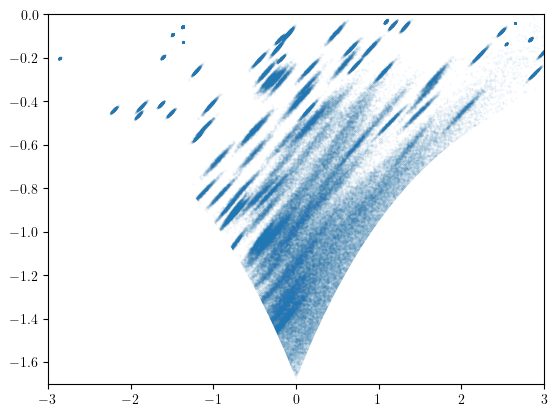

In [500]:
'''Draw samples from covariance matrix'''


for i in range(200):#len(L_z)):
    cov = 2 * D_mean[i] * t[-1] * np.array([[1, Omega_b_mean[i]], [Omega_b_mean[i], Omega_b2_mean[i]]])
    samples = np.random.multivariate_normal((L_z[i], E[i]), cov, 1000)

    plt.scatter(samples[:,0]/1e3, samples[:,1]/1e5, s=0.1, alpha=0.1, c='tab:blue')


# Calculate energy of circular planar orbits
rgrid = np.linspace(0.1, 40, 1000)
vcirc = v_c(rgrid)
Lz_circ = rgrid * vcirc
E_circ = 0.5 * vcirc**2 + Phi(rgrid)

plt.fill_between(Lz_circ/1e3, -5, E_circ/1e5, color='w')
plt.fill_between(-Lz_circ/1e3, -5, E_circ/1e5, color='w')

plt.xlim(-3, 3)
plt.ylim(-1.7, 0)



Text(0, 0.5, '$E$ [$10^5$ (km/s)$^2$]')

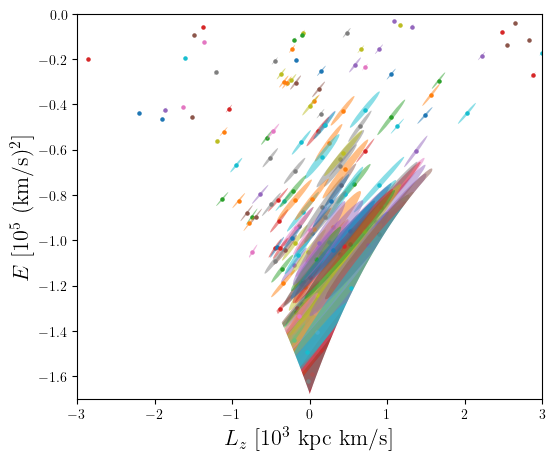

In [ ]:
from matplotlib import patches as mpatches

fig, ax = plt.subplots(figsize=(6,5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Omega_0 = 1e2
Lz_scale = 1e3

for i in range(200):#len(L_z)):
    centre = (L_z[i]/1e3, E[i]/1e5)
    p = Omega_b_mean[i] / Omega_0
    major_ax = 2*(2*D_mean[i]*t[-1] * (1 + p**2) * (1 + p**4 / (1 + p**2)**2 * alpha[i]))**0.5 / Lz_scale
    minor_ax = 2*(2*D_mean[i]*t[-1] * p**2 / (1 + p**2) * alpha[i])**0.5 / Lz_scale
    gradient = (1 + p**2 / (1 + p**2) * alpha[i]) * Omega_b_mean[i] / Omega_0
    angle_deg = np.arctan(gradient) * 180/np.pi

    patch = mpatches.Ellipse(xy=centre, width=major_ax, height=minor_ax, angle=angle_deg, fc=colors[i%10], alpha=0.5)#, fc='none', ls='solid', ec='g', lw='3.')
    ax.add_patch(patch)

    ax.scatter(L_z[i]/1e3, E[i]/1e5, s=5, c=colors[i%10])


ax.fill_between(Lz_circ/1e3, -5e6, E_circ/1e5, color='w')
ax.fill_between(-Lz_circ/1e3, -5e6, E_circ/1e5, color='w')

ax.set_xlim(-3, 3)
ax.set_ylim(-1.7, 0)

ax.set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
ax.set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:33: SyntaxWarning: invalid escape sequence '\O'
<>:34: SyntaxWarning: invalid escape sequence '\O'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:33: SyntaxWarning: invalid escape sequence '\O'
<>:34: SyntaxWarning: invalid escape sequence '\O'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_59351/4059348743.py:31: SyntaxWarning: invalid escape sequence '\e'
  cb.set_label('Circularity $\eta$', fontsize=16)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_59351/4059348743.py:33: SyntaxWarning: invalid escape sequence '\O'
  ax.axhline(Omega_b[-1], ls='--', c='k', label='Current $\Omega_\mathrm{b}$')
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_59351/4059348743.py:34: SyntaxWarning: invalid escape sequence '\O'
  ax.axhline(Omega_b.mean(), ls='--', c='tab:red', label='Mean $\Omega_\mathrm{b}$

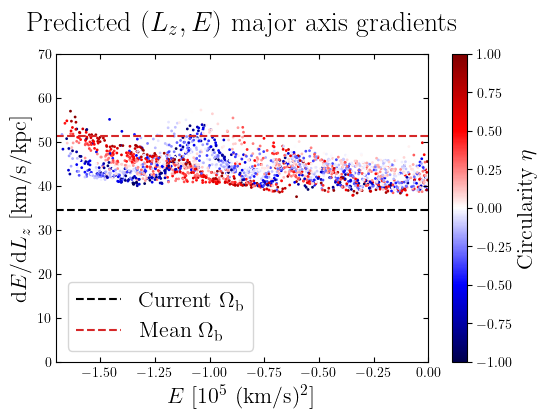

In [782]:
Omega_0 = 1e2
Lz_scale = 1e3

# for i in range(200):#len(L_z)):
# centre = (L_z[i]/1e3, E[i]/1e5)
p = Omega_b_mean / Omega_0

# p = Omega_b_mean
gradient = (1 + p**2 / (1 + p**2) * alpha) * Omega_b_mean
# angle_deg = np.arctan(gradient) * 180/np.pi

# Corotation energy
Rgrid = np.linspace(0.01, 20, 1000)
Omega_c = v_c(Rgrid) / Rgrid
R_CR = Rgrid[np.argmin(abs(Omega_c - Omega_b[-1]))]
E_CR = 0.5 * v_c(R_CR)**2 + Phi(R_CR)

Lz_grid = np.linspace(0, 100000, 10001)
E_circ = H(0, Lz_grid)

Lz_circ = np.interp(E, E_circ, Lz_grid)

eta = L_z / Lz_circ


fig, ax = plt.subplots(figsize=(6,4))

sc = ax.scatter(E/1e5, gradient, s=1, c=eta, cmap='seismic', vmin=-1, vmax=1)

cb = fig.colorbar(sc, ax=ax)
cb.set_label('Circularity $\eta$', fontsize=16)

ax.axhline(Omega_b[-1], ls='--', c='k', label='Current $\Omega_\mathrm{b}$')
ax.axhline(Omega_b.mean(), ls='--', c='tab:red', label='Mean $\Omega_\mathrm{b}$')

ax.legend(fontsize=16, loc=3)

ax.set_xlim(-1.7, 0)
ax.set_ylim(0, 70)

ax.set_xlabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)
ax.set_ylabel('$\mathrm{d}E/\mathrm{d}L_z$ [km/s/kpc]', fontsize=16)

ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

ax.set_title('Predicted $(L_z,E)$ major axis gradients', fontsize=20, y=1.05)

ax.set_rasterization_zorder(10)

plt.savefig(figpath+'predicted_gradients.pdf', bbox_inches='tight', dpi=200)




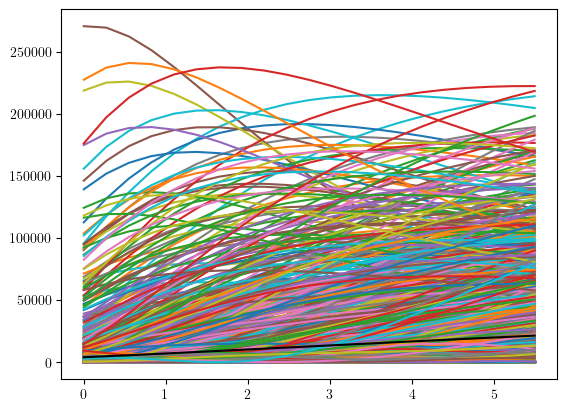

In [781]:
for i in range(2000):
    plt.plot(t, D[:,i])

plt.plot(t, np.mean(D, axis=-1), c='k')